# Capítulo 6 - Método Cross-Entropy


Você pode rodar este notebook no Colab. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap06/cap06-main.ipynb) 

Algumas coisas podem não funcionar diretamente se rodar localmente.

## 1. Configurações Iniciais

### Cria Diretório para Experimentos

In [ ]:
from IPython.display import clear_output
!mkdir results

### Configurações Dependentes do Sistema

Você pode rodar a célula abaixo, mesmo sem estar no Colab.

In [ ]:
import sys

if 'google.colab' in sys.modules:
    !pip install gym
    !pip install gym[box2d]
    !pip install optuna

    # para salvar videos
    !apt-get install -y xvfb x11-utils
    !pip install pyvirtualdisplay==0.2.*
    !apt-get install ffmpeg

    from pyvirtualdisplay import Display
    display = Display(visible=False, size=(1400, 900))
    _ = display.start()

    !git clone https://github.com/pablo-sampaio/rl_facil
    clear_output()

    !mv /content/rl_facil/cap04/* /content/
    !mv /content/rl_facil/cap05/* /content/
    !mv /content/rl_facil/cap06/* /content/

else:
    # atenção: para Windows 
    # ajuste aqui se estiver no Linux
    !copy ..\cap04\util_*.py .


### Configurações para Exibir Video

In [9]:
# ideias adaptadas de : https://www.anyscale.com/blog/an-introduction-to-reinforcement-learning-with-openai-gym-rllib-and-google
from base64 import b64encode
from IPython.display import HTML
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  html_code = f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'
  return HTML(html_code)

### Imports Principais

Algoritmos, ambientes e outros módulos.

In [4]:
import gym
import numpy as np
import optuna

from util_experiments import repeated_exec
from util_plot import plot_result, plot_multiple_results

#from montecarlo_v2 import run_montecarlo2
#from qlearning import run_qlearning
#from expected_sarsa import run_expected_sarsa
from models_torch import test_policy
from crossentropy_method import run_crossentropy_method

## 2. Rodando o Método Cross-Entropy

Últimos episódios do treinamento: media = -88.95 , desvio padrao = 22.690251210597033


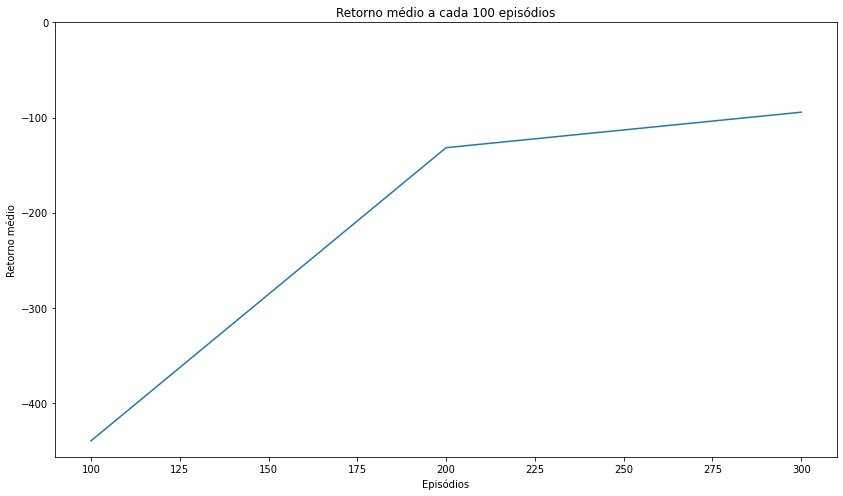

Nenhum arquivo salvo.


In [5]:
#ENV_NAME, rmax = "CartPole-v1", 500
ENV_NAME, rmax = "Acrobot-v1", 0
#ENV_NAME, rmax = "LunarLander-v2", 300
#ENV_NAME, rmax = "MountainCar-v0", 0  # resultados ruins
ENV = gym.make(ENV_NAME)

EPISODES =  300        # total de episódios
BATCH_SIZE = 10        # quantidade de episódios executados por época de treinamento
PERCENT_BEST = 0.2     # percentual dos episódios (do batch) que serão selecionados

returns, policy = run_crossentropy_method(ENV, EPISODES, BATCH_SIZE, PERCENT_BEST)
clear_output()

print("Últimos episódios do treinamento: media =", np.mean(returns[-20:]), ", desvio padrao =", np.std(returns[-20:]))

# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns, rmax, None)


In [6]:
# Faz alguns testes com o modelo de forma DETERMINÍSTICA e salva vídeo em arquivo
video = VideoRecorder(ENV, "politica-treinada.mp4")
test_policy(ENV, policy, True, 5, render=False, videorec=video)

EPISODE 1
- steps: 88
- return: -87.0
EPISODE 2
- steps: 78
- return: -77.0
EPISODE 3
- steps: 74
- return: -73.0
EPISODE 4
- steps: 93
- return: -92.0
EPISODE 5
- steps: 73
- return: -72.0
RESULTADO FINAL: média (por episódio): -80.2, episódios: 5, total de passos: 406


(-80.2, [-87.0, -77.0, -73.0, -92.0, -72.0])

In [10]:
render_mp4("politica-treinada.mp4")

## 3. Experimentos


### 3.1 Parâmetros do Cross-Entropy

Abaixo, mostramos experimentos variando os dois parâmetros mais diretos do método:
- o tamanho de batch (de episódios)
- a proporção dos episódios selecionados

***Atenção***: de forma geral, os resultados variam muito, porque dependem da inicialização da rede neural, que é aleatória. Então, para resultados mais confiáveis, é recomendando usar um número mais alto de repetições do que estamos usando abaixo. Tente com algumas *dezenas*.

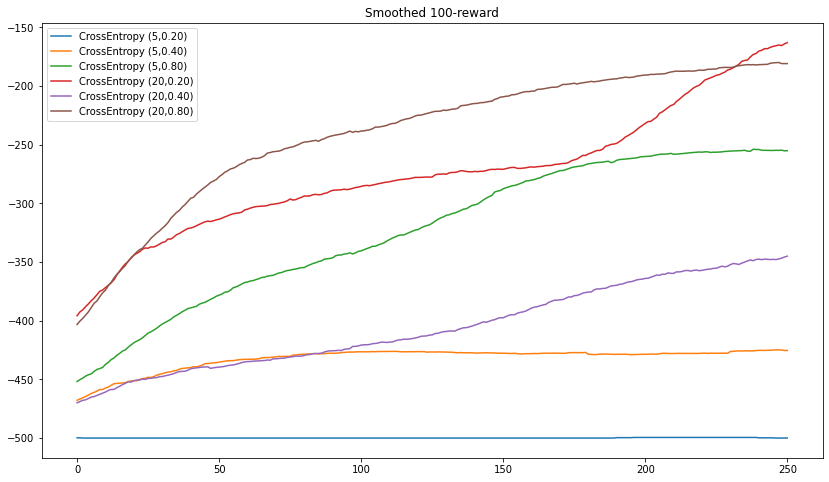

Summary for CrossEntropy (5,0.20)
 - sum rewards (all episodes): -149965.2

Summary for CrossEntropy (5,0.40)
 - sum rewards (all episodes): -130563.8

Summary for CrossEntropy (5,0.80)
 - sum rewards (all episodes): -98657.0

Summary for CrossEntropy (20,0.20)
 - sum rewards (all episodes): -83022.0

Summary for CrossEntropy (20,0.40)
 - sum rewards (all episodes): -121828.0

Summary for CrossEntropy (20,0.80)
 - sum rewards (all episodes): -74963.4



In [18]:
ENV = gym.make("Acrobot-v1")
NUM_EPISODES = 300

results = []

for batch_size in [5, 20]:
    #results = []
    for proportion in [1/5.0, 2/5.0, 4/5.0]:
        results.append( repeated_exec(5, f"CrossEntropy ({batch_size}; {proportion:.2f})", run_crossentropy_method, ENV, NUM_EPISODES, batch_size, proportion) )
        clear_output()
    #plot_multiple_results(results, cumulative=False, x_log_scale=False)

plot_multiple_results(results, cumulative=False, x_log_scale=False)


### 3.2 Parâmetros da Rede Neural (da Política)

Você também pode variar todos os parâmetros da rede neural: quantidade de camadas, taxa de aprendizagem, etc.

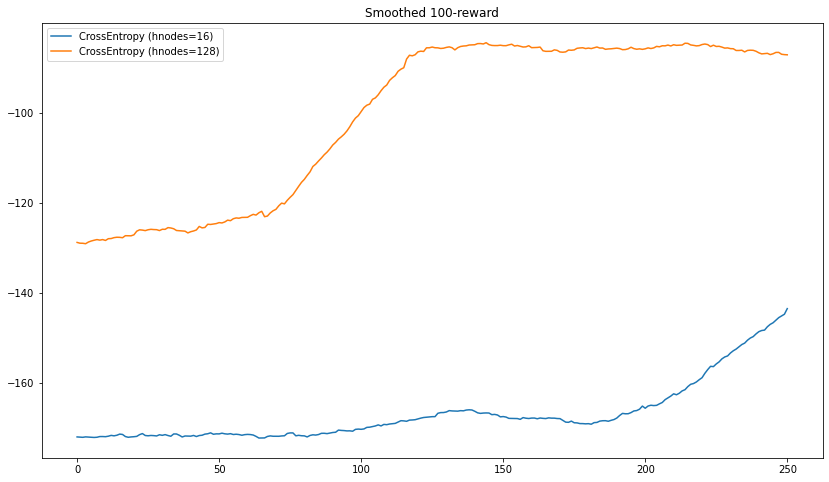

Summary for CrossEntropy (hnodes=16)
 - sum rewards (all episodes): -49537.7

Summary for CrossEntropy (hnodes=128)
 - sum rewards (all episodes): -30553.8



In [17]:
from models_torch import PolicyModelCrossentropy

ENV = gym.make("Acrobot-v1")

NUM_EPISODES = 300
BATCH_SIZE   = 5
PROPORTION   = 0.4

results = []

for hidden_layer_size in [16, 128]:
    policy_model = PolicyModelCrossentropy(ENV.observation_space.shape[0], [hidden_layer_size], ENV.action_space.n, lr=0.01)
    results.append( repeated_exec(10, f"CrossEntropy (hnodes={hidden_layer_size})", run_crossentropy_method, ENV, NUM_EPISODES, BATCH_SIZE, PROPORTION, policy_model) )
    clear_output()

plot_multiple_results(results, cumulative=False, x_log_scale=False)